In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import openpyxl
import re
from tqdm import tqdm


In [42]:
plt.rcParams["svg.fonttype"] = "none"

In [43]:
workbook = 'article_info.xlsx'
# workbook = openpyxl.load_workbook(workbook)
# sheet = workbook['articles_selected']

In [58]:
#cinvert the excel sheet to pandas dataframe
article_data = pd.read_excel(workbook, sheet_name='articles_clean')

In [59]:
article_data = article_data[["citation", "n_participants", "dataset", "p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association", "effect"]]

In [60]:
structuraL_biomarkers = ["GMV", "subGMV", "CT", "SA", "f1", "f2", "FA", "RD", "MD", "MO", "SC", "AD", "T1w/T2w", "CD", "L1"]

In [61]:
from itertools import product

def expand_row(row, columns):
    # Split the values in each column and create a product of all combinations
    combinations = product(
        *(str(row[col]).split(', ') for col in columns)
    )
    # Create a list of dictionaries for each combination
    expanded_rows = [
        {**{col: val for col, val in zip(columns, combo)}, **row.drop(columns)}
        for combo in combinations
    ]
    return expanded_rows

# Columns to expand
columns_to_expand = ["p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association"]

# Apply the expand_row function to each row
expanded_data = [expand_row(row, columns_to_expand) for index, row in article_data.iterrows()]

# Flatten the list of lists into a single list of dictionaries
flat_data = [item for sublist in expanded_data for item in sublist]

# Convert the list of dictionaries back into a DataFrame
expanded_df = pd.DataFrame(flat_data)
# expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'structural') & 
#                              (expanded_df['biomarker'] == 'FC')) |
#                             ((expanded_df['biomarker_type'] == 'structural') & 
#                              (expanded_df['biomarker'] == 'CBF')))]

expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'structural') & 
                             (expanded_df['biomarker'].isin(["FC", "CBF"]))))]

expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'functional') & 
                             (expanded_df['biomarker'].isin(structuraL_biomarkers))))]

In [62]:
def is_valid_combination(row, original_df):
    if ',' in str(row['association']):  # Check only rows with multiple values in 'association'
        # Find the original row(s) this row could have been expanded from
        original_rows = original_df[
            (original_df['citation'] == row['citation']) &
            (original_df['n_participants'] == row['n_participants']) &
            (original_df['dataset'] == row['dataset'])
        ]

        for _, original_row in original_rows.iterrows():
            # Split the original values into lists
            original_associations = str(original_row['association']).split(', ')
            original_biomarkers = str(original_row['biomarker']).split(', ')

            # Check if the current combination exists in the original row
            if len(original_associations) == len(original_biomarkers):
                try:
                    index = original_biomarkers.index(row['biomarker'])
                    if original_associations[index] == row['association']:
                        return True
                except ValueError:
                    continue
        return False
    else:
        return True

# Apply the is_valid_combination function
expanded_df = expanded_df[expanded_df.apply(is_valid_combination, axis=1, original_df=article_data)]

In [63]:
expanded_df[expanded_df['association'] == 'nan']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,citation,n_participants,dataset,effect
249,INT,Bifactor,FM,functional,nan,Reimann et al. (2023),3568,ABCD,0.0007
250,ADHD,Bifactor,FM,functional,nan,Reimann et al. (2023),3568,ABCD,0.0007
251,conduct,Bifactor,FM,functional,nan,Reimann et al. (2023),3568,ABCD,0.0007
271,INT,Bifactor,FA,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
272,INT,Bifactor,MD,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
273,ADHD,Bifactor,FA,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
274,ADHD,Bifactor,MD,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
275,conduct,Bifactor,FA,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
276,conduct,Bifactor,MD,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN


In [64]:
# replace functional with Functional
expanded_df['biomarker_type'] = expanded_df['biomarker_type'].replace('functional', 'Functional')
expanded_df['biomarker_type'] = expanded_df['biomarker_type'].replace('structural', 'Structural')
expanded_df['association'] = expanded_df['association'].replace('pos', 'Positive')
expanded_df['association'] = expanded_df['association'].replace('neg', 'Negative')
# expanded_df['association'] = expanded_df['association'].replace('nan', 'NULL')

In [66]:
expanded_df[expanded_df['association'] == 'nan']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,citation,n_participants,dataset,effect
249,INT,Bifactor,FM,Functional,nan,Reimann et al. (2023),3568,ABCD,0.0007
250,ADHD,Bifactor,FM,Functional,nan,Reimann et al. (2023),3568,ABCD,0.0007
251,conduct,Bifactor,FM,Functional,nan,Reimann et al. (2023),3568,ABCD,0.0007
271,INT,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
272,INT,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
273,ADHD,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
274,ADHD,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
275,conduct,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN
276,conduct,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN


In [67]:
expanded_df

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,citation,n_participants,dataset,effect
0,INT,EFA,FC,Functional,Negative,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84"
1,INT,EFA,FC,Functional,Negative,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84"
2,INT,EFA,FC,Functional,Positive,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84"
3,INT,EFA,FC,Functional,Positive,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84"
4,EXT,EFA,FC,Functional,Negative,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84"
...,...,...,...,...,...,...,...,...,...
283,INT,Higher-order,SA,Structural,Negative,Mewton et al. (2022),11721,ABCD,"-0.034, -0.033"
284,EXT,Higher-order,GMV,Structural,Negative,Mewton et al. (2022),11721,ABCD,"-0.034, -0.033"
285,EXT,Higher-order,SA,Structural,Negative,Mewton et al. (2022),11721,ABCD,"-0.034, -0.033"
286,thought disorder,Higher-order,GMV,Structural,Negative,Mewton et al. (2022),11721,ABCD,"-0.034, -0.033"


In [68]:
expanded_df.to_csv('expanded_article_data.csv', index=False)

In [54]:
expanded_df = pd.read_csv('expanded_article_data.csv')

## Sorting by Effect & Data Modality

In [69]:
df_associations_biomarkers = expanded_df.drop_duplicates(subset=['citation', 'biomarker', 'biomarker_type', 'association'])

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_18723/1309218564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associations_biomarkers['biomarker_type_jittered'] = df_associations_biomarkers['biomarker_type'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(df_associations_biomarkers))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_18723/1309218564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associations_biomarkers['association_jittered'] = 

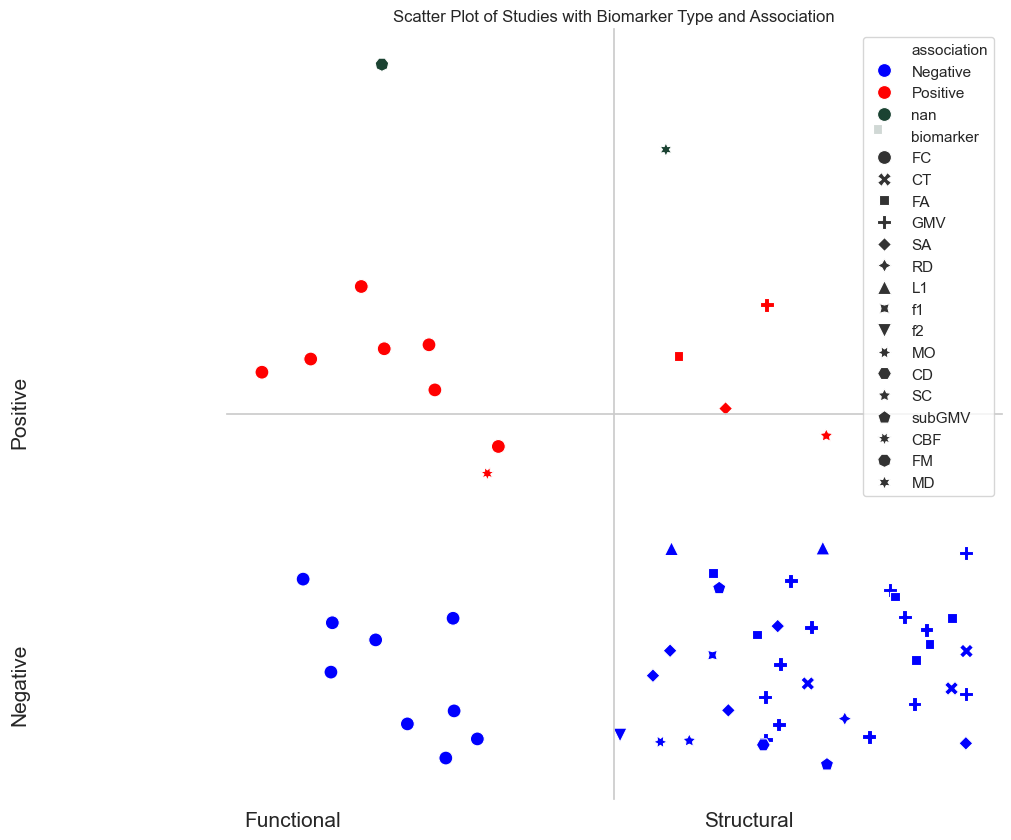

In [70]:
# for this plot only keep the rows with unique combinations of biomarker,biomarker_type	and association
df_associations_biomarkers = expanded_df.drop_duplicates(subset=['citation', 'biomarker', 'biomarker_type', 'association'])
df_associations_biomarkers['biomarker_type_jittered'] = df_associations_biomarkers['biomarker_type'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(df_associations_biomarkers))
df_associations_biomarkers['association_jittered'] = df_associations_biomarkers['association'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(df_associations_biomarkers))

# Create a scatter plot
plt.figure(figsize=(10, 10))

# Plotting the scatter plot
sns.scatterplot(data=df_associations_biomarkers, x='biomarker_type_jittered', y='association_jittered', hue='association', style='biomarker', s=100, palette=['#0000fe', '#ff0000', "#1b4332"])


# # Annotate each point with its citation
# for i, row in expanded_df.iterrows():
#     plt.text(row['biomarker_type_jittered'], row['association_jittered'], row['citation'], horizontalalignment='right', alpha=0.7, fontsize=11)

# Adding axis annotations for 'Negative/Positive' and 'Functional/Structural' directions
biomarker_categories = df_associations_biomarkers['biomarker_type'].astype('category').cat.categories
association_categories = df_associations_biomarkers['association'].astype('category').cat.categories

# Place biomarker type and association annotations
plt.text(biomarker_categories.get_loc('Functional') + 0.6, 0.1, 'Functional', ha='center', va='center', fontsize=15)
plt.text(biomarker_categories.get_loc('Structural') + 0.6, 0.1, 'Structural', ha='center', va='center', fontsize=15)
plt.text(0.000001, association_categories.get_loc('Positive') + 0.6, 'Positive', ha='center', va='center', rotation=90, fontsize=15)
plt.text(0.000001, association_categories.get_loc('Negative') + 0.6, 'Negative', ha='center', va='center', rotation=90, fontsize=15)


# Remove the default x and y ticks and labels
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# Set the origin in the middle
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['left'].set_position('center')

# Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Scatter Plot of Studies with Biomarker Type and Association')
plt.savefig('scatter_plot.svg', format = 'svg', dpi=300)
plt.show()



## Effects

In [15]:
df_associations_biomarkers


,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,citation,n_participants,dataset,effect,biomarker_type_jittered,association_jittered
0,internalizing,EFA,FC,Functional,Negative,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84",0.952809,0.629235
2,internalizing,EFA,FC,Functional,Positive,"Hong, Hwang, & Lee (2023)",6905,ABCD,"-3.53, -9.08, 3.2, 3.84",0.471296,1.342240
8,internalizing,Bifactor,FC,Functional,Negative,Sripada et al. (2021),6593,ABCD,from -0.05 to 0.04,0.779832,0.442639
10,internalizing,Bifactor,FC,Functional,Positive,Sripada et al. (2021),6593,ABCD,from -0.05 to 0.04,0.795995,1.363452
16,internalizing,Bifactor,CT,Structural,Negative,Romer et al. (2021),861,Dunedin,-0.159,1.627859,0.325319
...,...,...,...,...,...,...,...,...,...,...,...
271,internalizing,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN,1.378232,2.418992
272,internalizing,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD,NaN,1.618895,2.831816
277,anxious-misery,Bifactor,GMV,Structural,Negative,Kaczkurkin et al. (2019),1394,PNC,-0.14,1.976508,0.583048
282,internalizing,Higher-order,GMV,Structural,Negative,Mewton et al. (2022),11721,ABCD,"-0.034, -0.033",1.637662,0.488901


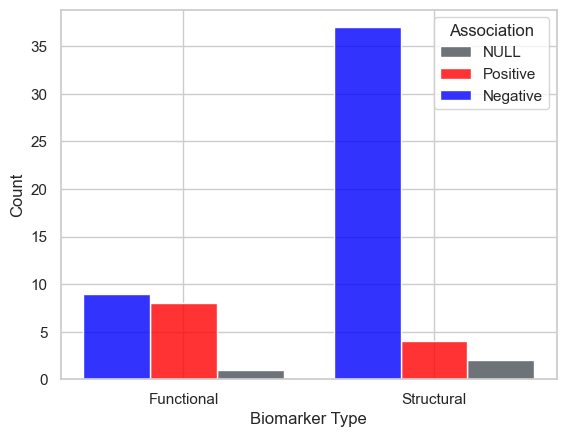

In [71]:
# sns.histplot(data=df_associations_biomarkers, x='biomarker_type', hue='association', multiple='stack', palette=['#0000fe', '#ff0000', '#495057'], shrink=0.8)

sns.set_theme(style="whitegrid")
sns.histplot(data=df_associations_biomarkers, x="biomarker_type", hue="association", multiple="dodge", shrink=.8, palette=['#0000fe', '#ff0000', '#495057'], alpha=0.8)
plt.xlabel('Biomarker Type')
plt.legend(title='Association', labels=['NULL','Positive', 'Negative'])
plt.savefig('histplot_associations.svg', format = 'svg', dpi=300)


In [18]:
biomarker_colors = [
    '#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', 
    '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff', 
    '#ff5b77', '#a42400', '#001146', '#0094cc', '#e0e0e0', 
    '#000000'
]

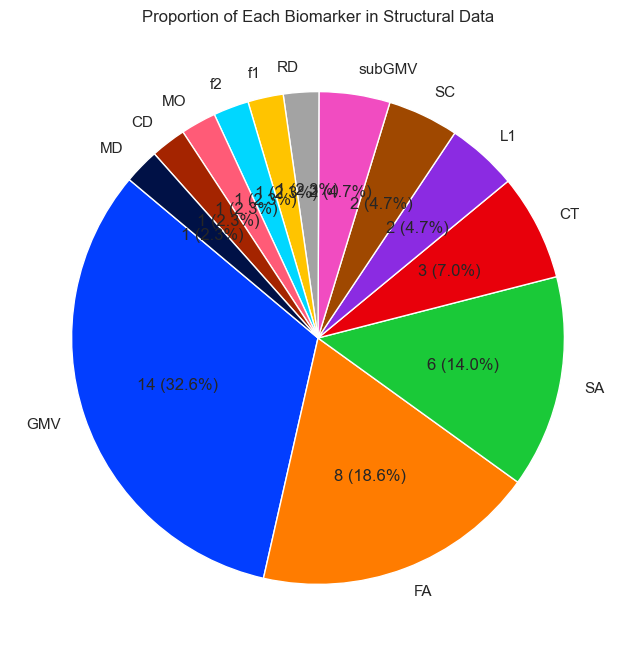

In [19]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v} ({p:.1f}%)'.format(p=pct,v=val)
    return my_format

df_associations_biomarkers_neg = df_associations_biomarkers[df_associations_biomarkers['biomarker_type'] == 'Structural']
biomarker_counts = df_associations_biomarkers_neg['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct=autopct_format(biomarker_counts), startangle=140, colors=biomarker_colors)
plt.title('Proportion of Each Biomarker in Structural Data')
plt.savefig('pie_plot_structural.svg', format = 'svg', dpi=300)
plt.show()

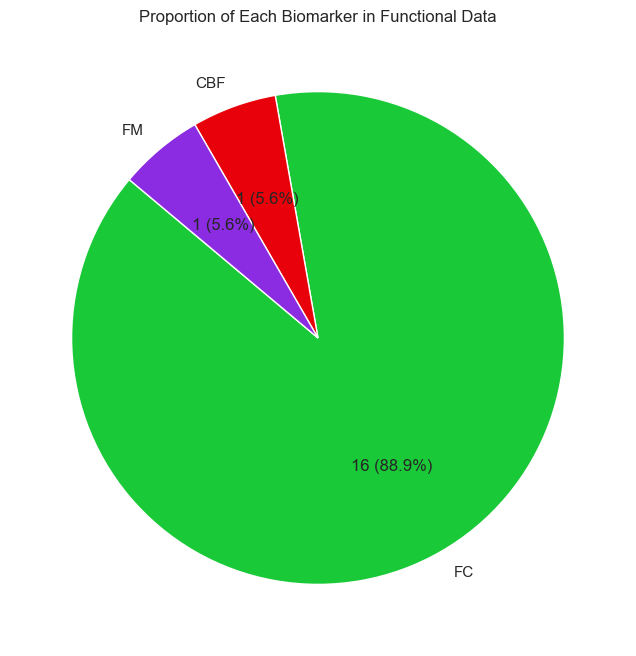

In [20]:
biomarker_colors = ['#1ac938', '#e8000b', '#8b2be2']
df_associations_biomarkers_func = df_associations_biomarkers[df_associations_biomarkers['biomarker_type'] == 'Functional']
biomarker_counts = df_associations_biomarkers_func['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct=autopct_format(biomarker_counts), startangle=140, colors=biomarker_colors)
plt.title('Proportion of Each Biomarker in Functional Data')
plt.savefig('pie_plot_functional.svg', format = 'svg', dpi=300)
plt.show()

In [ ]:
df_associations_biomarkers_pos = df_associations_biomarkers[df_associations_biomarkers['association'] == 'Positive']
biomarker_counts = df_associations_biomarkers_neg['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Biomarker')
plt.show()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_12805/2276295082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associations_biomarkers['biomarker'] = df_associations_biomarkers['biomarker'].astype('category')
/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1000x1000 with 0 Axes>

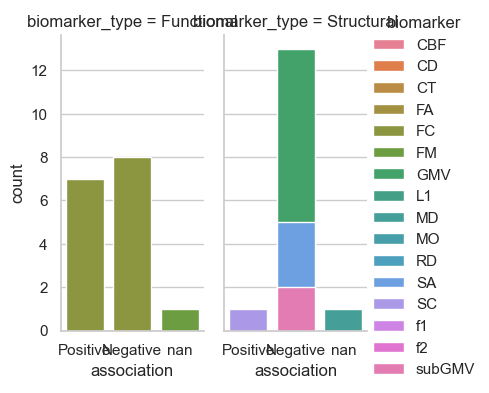

In [70]:
df_associations_biomarkers['biomarker'] = df_associations_biomarkers['biomarker'].astype('category')
# change figure size
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df_associations_biomarkers, col="biomarker_type", hue = "biomarker", height=4, aspect=.5)
g.map(sns.countplot, "association").add_legend()
#sns.histplot(data=df_associations_biomarkers, x="asso", hue="association", multiple="stack", shrink=.8, palette=['#0000fe', '#ff0000', '#495057'])
#plt.xlabel('Biomarker Type')
#plt.legend(title='Association', labels=['Negative','Positive', 'NULL'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


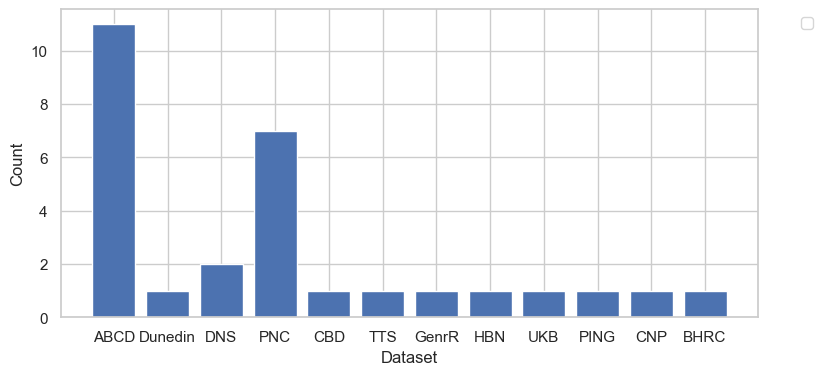

In [73]:

df_datasets = expanded_df.drop_duplicates(subset=['citation', 'dataset'])
# remove rows with nans in p_factor_dims
plt.figure(figsize=(9, 4))
sns.histplot(data=df_datasets, x='dataset', shrink=0.8, alpha = 1)
sns.set_theme(style="whitegrid")
plt.xlabel('Dataset')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('datasets_hist.svg', format = 'svg', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


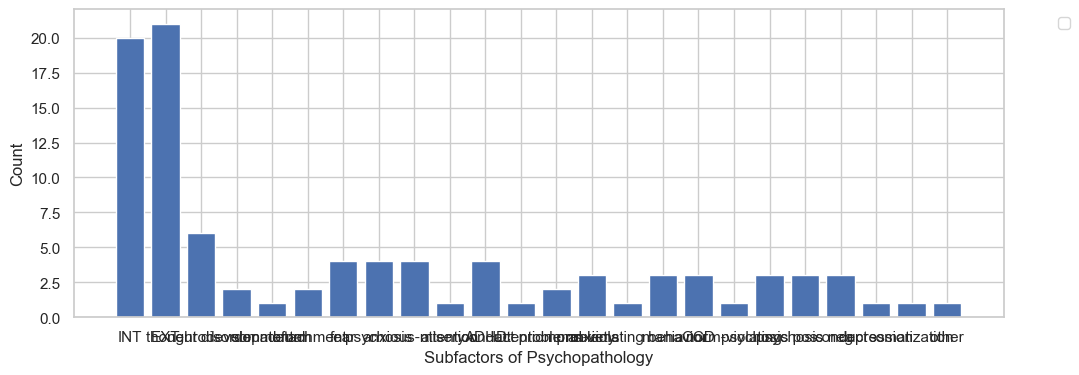

In [76]:
plt.figure(figsize=(12, 4))
df_datasets = expanded_df.drop_duplicates(subset=['citation', 'p_factor_dims'])
# remove rows with nans in p_factor_dims
df_datasets = df_datasets[df_datasets['p_factor_dims'] != 'nan']
sns.histplot(data=df_datasets, x='p_factor_dims', shrink=0.8, alpha = 1)
sns.set_theme(style="whitegrid")
plt.xlabel('Subfactors of Psychopathology')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('p_factor_dims_hist.svg', format = 'svg', dpi=300)

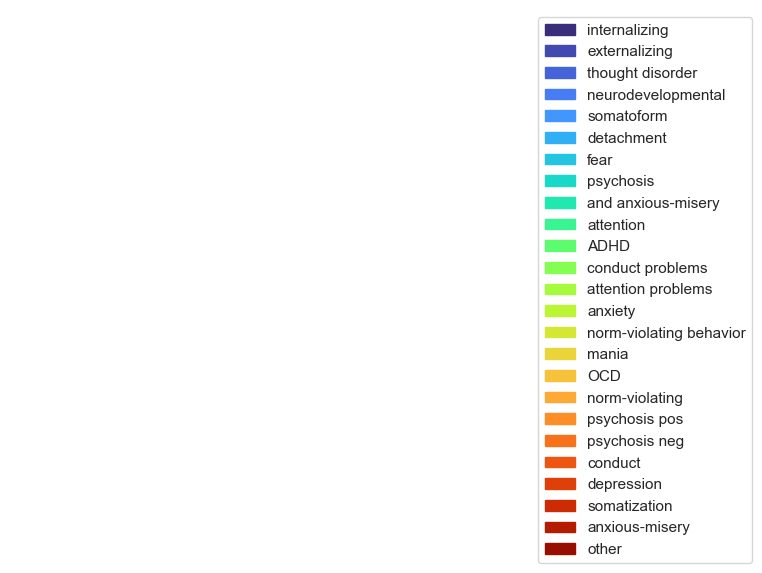

In [81]:
import matplotlib.patches as mpatches

# Define the colors and labels for your legend
colors = sns.color_palette("turbo", len(df_datasets['p_factor_dims'].unique()))
labels = df_datasets['p_factor_dims'].unique()

# Create a list of patches for the legend
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Create the legend
fig, ax = plt.subplots()
legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide the axes
ax.axis('off')

# Show the legend
plt.show()

In [ ]:
latent_method = article_data[["citation", "p_factor_analysis"]]

## Dataset and Pfactor Method Frequency

In [4]:

article_data = pd.read_excel(workbook, sheet_name='dataset_pfactor_method')
dataset_data = article_data[["citation", "dataset"]].drop_duplicates(subset = ["citation"])
latent_method = article_data[["citation", "p_factor_analysis"]]

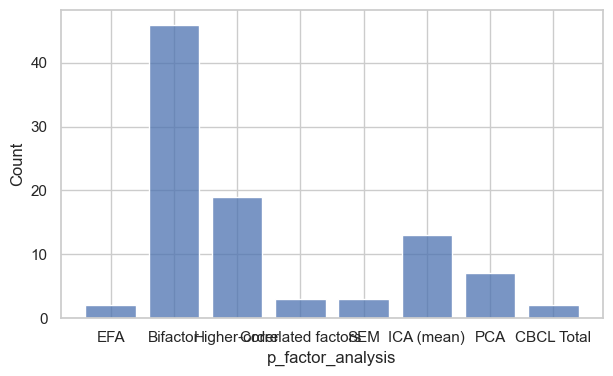

In [78]:
plt.figure(figsize=(7, 4))
sns.histplot(data=df_datasets, x='p_factor_analysis', multiple='stack', shrink=0.8, legend=False)
plt.savefig('p_factor_analysis_histplot.svg', format = 'svg', dpi=300)

<AxesSubplot: xlabel='dataset', ylabel='Count'>

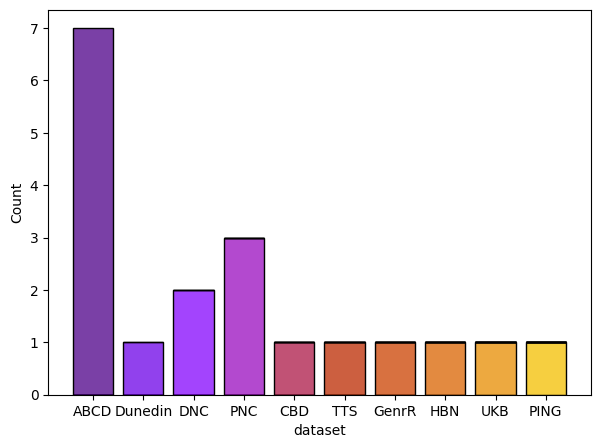

In [5]:
plt.figure(figsize=(7, 5))
sns.histplot(data=dataset_data, x='dataset', hue='dataset', multiple='stack', shrink=0.8, legend=False, palette="gnuplot")

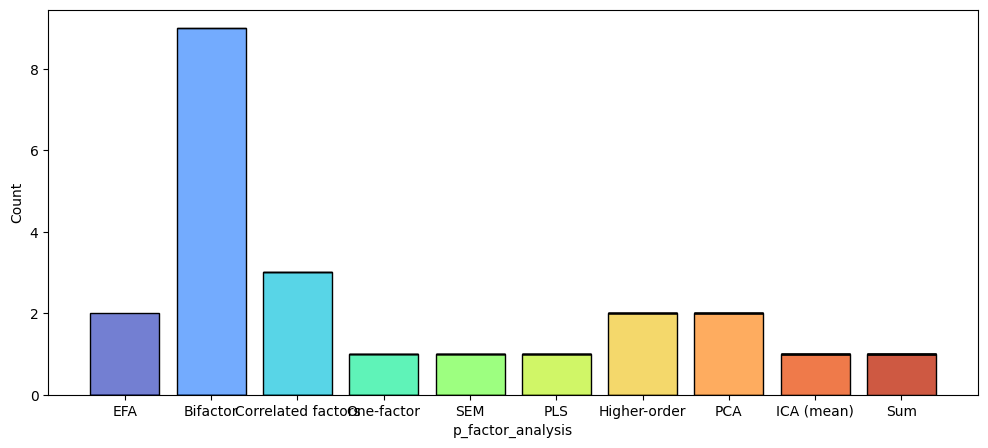

In [9]:
plt.figure(figsize=(12, 5))
sns.histplot(data=latent_method, x='p_factor_analysis', hue='p_factor_analysis', multiple='stack', shrink=0.8, legend=False, palette = "turbo")
plt.savefig('p_factor_analysis_histplot.svg', format = 'svg', dpi=300)

## Psy Dimensions

In [20]:
dim_data = pd.read_excel(workbook, sheet_name='dimensions')
dim_data = dim_data[["citation", "p_factor_dims"]]


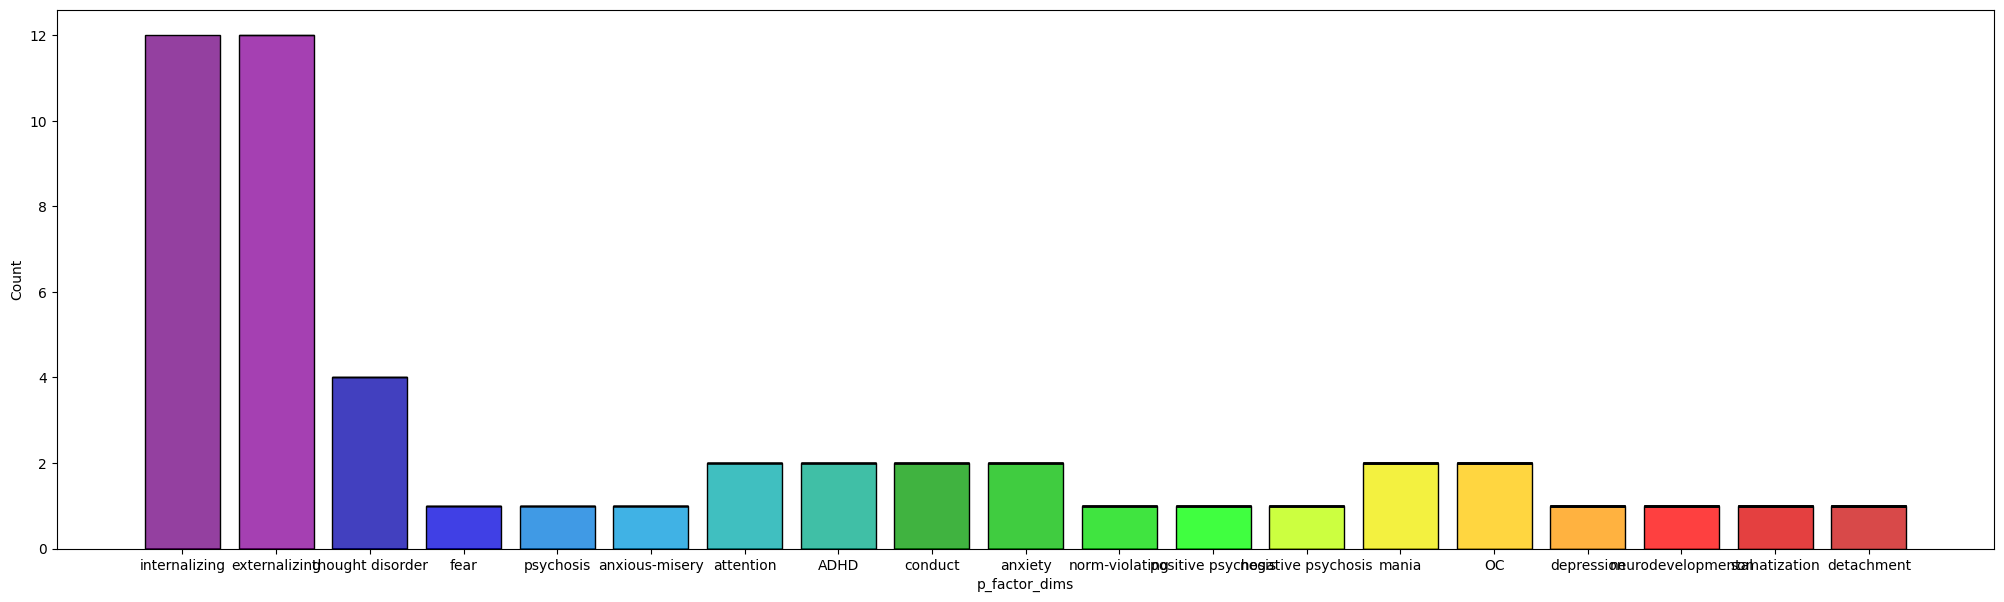

In [23]:
plt.figure(figsize=(25, 7))
sns.histplot(data=dim_data, x='p_factor_dims', hue='p_factor_dims', multiple='stack', shrink=0.8, legend=False, palette = "nipy_spectral")
plt.savefig('p_factor_dims_histplot.svg', format = 'svg', dpi=300)